In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch

from accelerate import notebook_launcher

from utils.data_utils import BrainDataset, process_file_last
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights

from dataclasses import dataclass
from simple_parsing.helpers import Serializable

import albumentations as A

import matplotlib.pyplot as plt
import gc

In [2]:
from models.brain_mae import EncoderConfig, Encoder, MAE, MAEConfig

In [3]:
encoder_config = EncoderConfig()
mae_config = MAEConfig()
model = MAE(encoder_config=encoder_config, mae_config=mae_config)


EncoderConfig(window_size=16, n_electrodes=256, time_patch_size=4, n_features=4, n_layers=12, dim=512, hidden_dim=2048, head_dim=32, n_heads=16, n_kv_heads=16)
Simple Encoder: number of parameters: 50.50M
mae_config MAEConfig(masking_ratio=0.5, n_layers=6, dim=512, hidden_dim=2048, head_dim=32, n_heads=16, n_kv_heads=16)
Full MAE: number of parameters: 75.94M


In [4]:
# data_path = Path("/drive/data/competitionData")
data_path = Path(r'D:\Work\brain-to-text-competition\data\competitionData')

tokenize_function = None
process_file_function = process_file_last

window_size = encoder_config.window_size
window_size = 128
n_electrodes = 256 * 4
max_tokens = 25

train_transform = A.Compose([
    A.RandomCrop(height=window_size, width=n_electrodes, always_apply=True),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=window_size, min_width=n_electrodes, position='top_left', 
                  border_mode=0, value=0, always_apply=True),
    A.Crop(x_min=0, x_max=n_electrodes, y_min=0, y_max=window_size, always_apply=True)
])



# train_dataset = BrainDataset(data_path / 'train', 
#                              process_file_function=process_file_function, 
#                              tokenize_function=tokenize_function, 
#                              transform=train_transform, 
#                              max_tokens=max_tokens)

# gc.collect()
test_dataset = BrainDataset(data_path / 'test', 
                            process_file_function=process_file_function, 
                            tokenize_function=tokenize_function, 
                            transform=test_transform, 
                            max_tokens=max_tokens)


# submit_dataset = BrainDataset(data_path / 'competitionHoldOut', 
#                             process_file_function=process_file_function, 
#                             tokenize_function=tokenize_function, 
#                             transform=test_transform, 
#                             max_tokens=max_tokens)

gc.collect()


# train_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset, submit_dataset])
# test_dataset = submit_dataset
# print(len(train_dataset))

Runed processing of the  D:\Work\brain-to-text-competition\data\competitionData\test


Processing files: 100%|██████████| 24/24 [00:08<00:00,  2.74file/s]


len of the dataset: 880
max signal size: 919 | max tokens size: 86
median signal size: 283.5 | median tokens size: 30.0


0

In [5]:
from einops import rearrange, repeat

In [46]:
def get_reconstruction(x, date_info, model, device='cuda'):
    ws = model.encoder_config.window_size
    n_samples = x.size(1) // ws

    x = x[:, :int(n_samples*ws)]
    
    x_rearranged = rearrange(x, 'b (t ws)  c -> (b t) ws c', ws=ws) 
    date_info = repeat(date_info, 'b 1 -> (b t) 1', t=n_samples)

    # print(x_rearranged.shape, date_info.shape)

    x_rearranged = x_rearranged.to(device)
    date_info = date_info.to(device)
    with torch.no_grad():
        loss, recon, binary  = model(x_rearranged, date_info=date_info, return_preds=True)
        # features = torch.mean(features[:, 1:], dim=1) # bt, d
        # features = features[:, 0]
    print(recon.shape, binary.shape)
    recon = rearrange(recon,  '(b t) ws c -> b (t ws) c', t=n_samples) 
    binary = rearrange(binary, '(b t) ws c -> b (t ws) c', t=n_samples) 
    

    recon  = recon.detach().cpu().numpy()
    binary = binary.detach().cpu().numpy()
    x = x.detach().cpu().numpy()

    return x, recon, binary


def get_features(x, date_info, model, device='cuda'):
    ws = model.encoder_config.window_size
    n_samples = x.size(1) // ws

    x = x[:, :int(n_samples*ws)]
    
    x_rearranged = rearrange(x, 'b (t ws)  c -> (b t) ws c', ws=ws) 
    date_info = repeat(date_info, 'b 1 -> (b t) 1', t=n_samples)

    # print(x_rearranged.shape, date_info.shape)

    x_rearranged = x_rearranged.to(device)
    date_info = date_info.to(device)
    with torch.no_grad():
        features = model.encoder(x_rearranged, date_info=date_info)
        # features = torch.mean(features[:, 1:], dim=1) # bt, d
        features = features[:, 0]
    features = rearrange(features, '(b t) d -> b t d', t=n_samples) 

    features = features.detach().cpu().numpy()
    return features





In [41]:
import safetensors
weights = r'D:\Work\brain-to-text-competition\step_4000_loss_0.0135.safetensors'

st_dict_compiled = safetensors.torch.load_file(weights)

new_dict = {}
for  k, v in st_dict_compiled.items():
    new_dict[k.replace('_orig_mod.', '')] = v

# s1=s.replace("$","")
model.load_state_dict(new_dict)
model = model.eval()

In [42]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [43]:
from tqdm import tqdm 
import numpy as np
from einops import repeat

In [83]:
device = 'cuda'
model.to(device)

all_features = []
dates_list = []
i = 0 
for x, txt, date_info in tqdm(test_dataloader):
    x, recon, binary = get_reconstruction(x, date_info, model)
    
    break
    # if i > 4:
        # break

  0%|          | 0/220 [00:03<?, ?it/s]

torch.Size([32, 16, 1024]) torch.Size([32, 16, 1024])


In [109]:
def visualize_data(x, recon, binary_mask, n_ch=0):
    x_masked_input = binary_mask * x
    x_unmasked_input = ~binary_mask * x

    recon_masked = binary_mask * recon
    recon_unmasked = ~binary_mask * recon

    t_st, t_end = 0, 64
    electrode = n_ch
    
    c_st, c_end = electrode , 1280
    ch_slice = slice(c_st, c_end, 256)

    
    fig, ax = plt.subplots(3,2, figsize = (8, 4))
    ax[0, 0].imshow(x[t_st:t_end, ch_slice].T, vmax=1, aspect='auto')
    ax[1, 0].imshow(x_unmasked_input[t_st:t_end, ch_slice].T, vmax=1, aspect='auto')
    ax[2, 0].imshow(x_masked_input[t_st:t_end, ch_slice].T, vmax=1, aspect='auto')

    ax[0, 1].imshow(recon[t_st:t_end, ch_slice].T, vmax=1, aspect='auto')
    ax[1, 1].imshow(recon_unmasked[t_st:t_end, ch_slice].T, vmax=1, aspect='auto')
    ax[2, 1].imshow(recon_masked[t_st:t_end, ch_slice].T, vmax=1, aspect='auto')

C:\Users\aleksandr.kovalev\AppData\Local\Temp\ipykernel_22464\3509880448.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  visualize_data(x[3], recon[3], binary[3].astype(np.bool), n_ch=i)


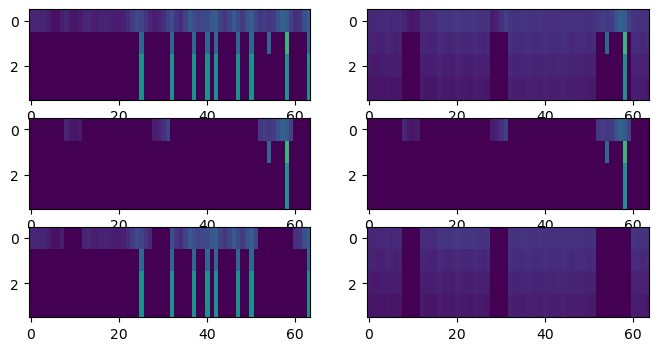

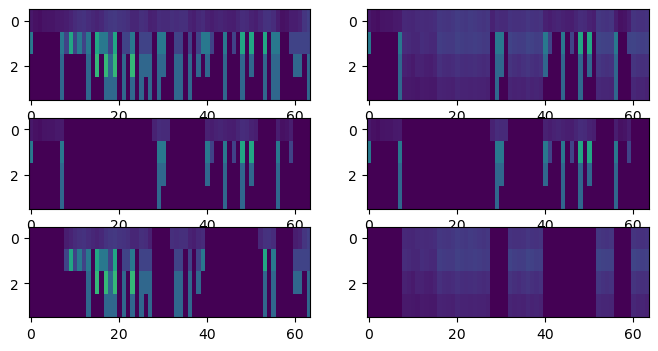

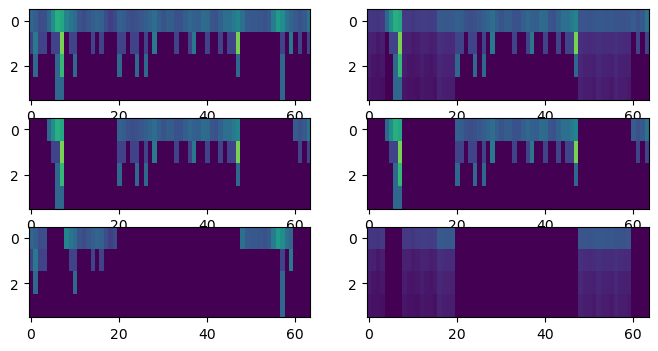

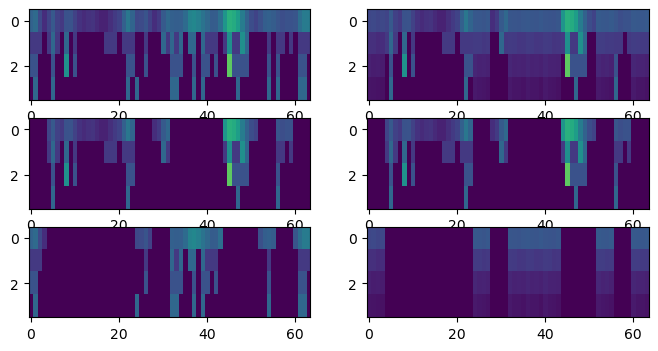

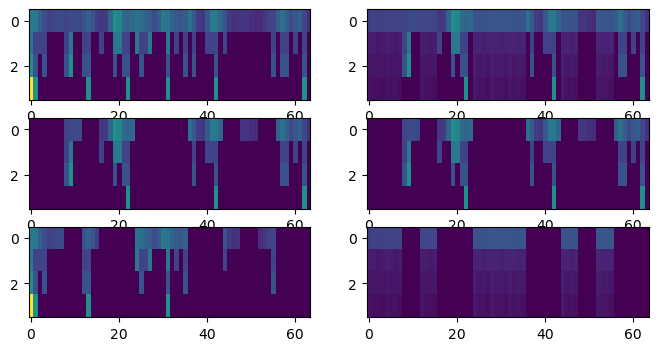

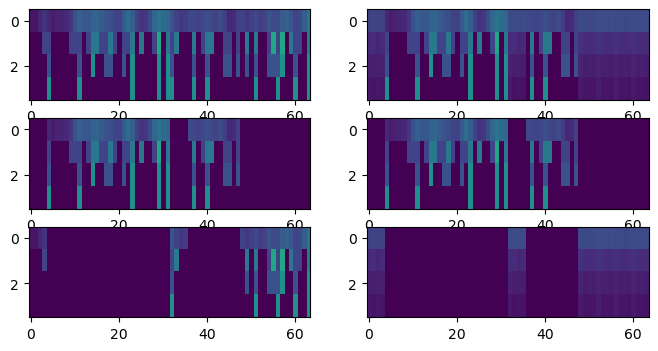

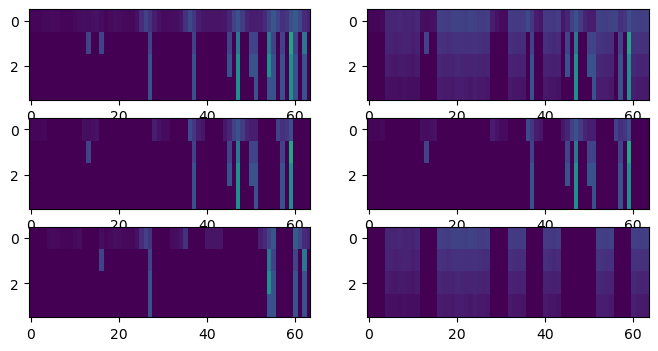

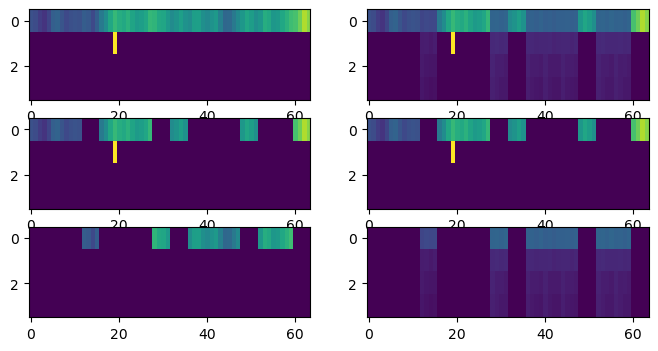

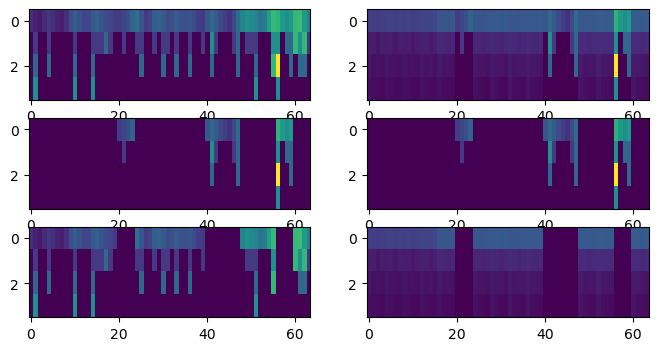

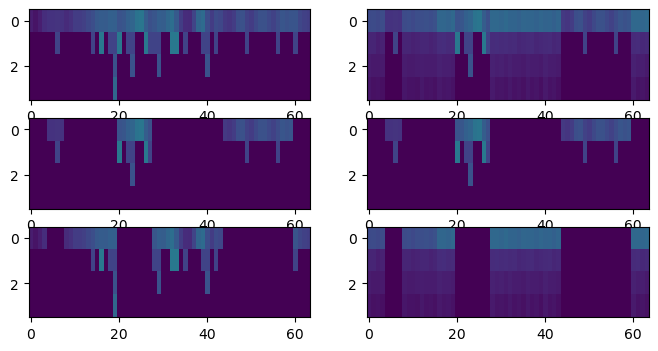

In [110]:
for i in range(10):
    visualize_data(x[3], recon[3], binary[3].astype(np.bool), n_ch=i)
    plt.show()

In [85]:
recon.shape, binary.shape, x.shape

((4, 128, 1024), (4, 128, 1024), (4, 128, 1024))

In [75]:
device = 'cuda'
model.to(device)

all_features = []
dates_list = []
i = 0 
for x, txt, date_info in tqdm(test_dataloader):
    features = get_features(x, date_info, model)
    all_features.append(features)
    dates_list.append(date_info.numpy())
    i = i + 1
    # if i > 4:
        # break
all_features = np.stack(all_features, axis=0)

dates_list = np.stack(dates_list)
dates_list = repeat(dates_list, 'n b 1 -> n (b s) 1', s=window_size//model.encoder_config.window_size)

np.save('features_cls', all_features)

  1%|▏         | 3/220 [00:14<17:44,  4.90s/it]


KeyboardInterrupt: 

In [17]:
all_features.shape, dates_list.shape

((220, 4, 8, 512), (220, 32, 1))

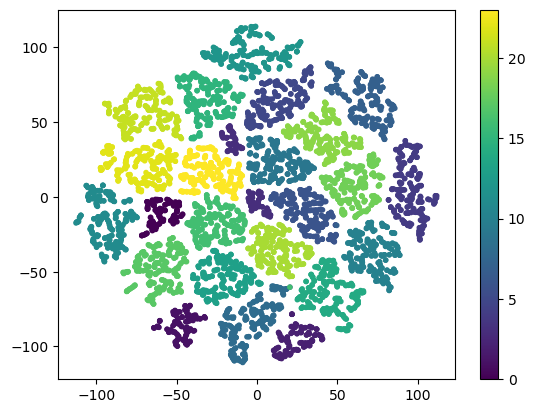

In [12]:
import numpy as np
from sklearn.manifold import TSNE
X = all_features.reshape(-1, 512)
y = dates_list.reshape(-1)

# X = X[:500]
# y = dates[:500]

# y = y

day_filter = (y==21)
# X = X[day_filter]
# y = y[day_filter]

X_embedded = TSNE(n_components=2, 
                  learning_rate='auto',
                  init='random', 
                  perplexity=5, 
                  early_exaggeration=12, 
                  n_iter_without_progress=300,
                  metric='euclidean').fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='.', c=y)
plt.colorbar()

In [13]:
X.shape

(7040, 512)

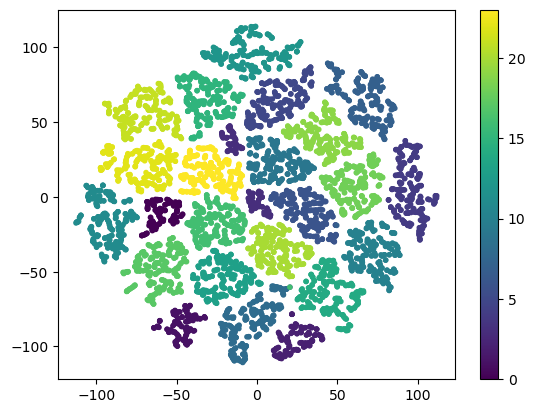

In [14]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='.', c=y)
plt.colorbar()

In [15]:
X_embedded = PCA(n_components=2).fit_transform(X)


NameError: name 'PCA' is not defined

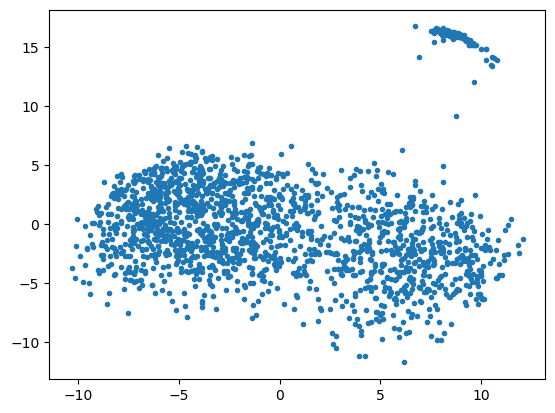

In [ ]:
mae_config = MAEConfig()
model = MAE(encoder_config=encoder_config, mae_config=mae_config)


y_hat = model(x, date_info=date_info, return_preds=True)
print(y_hat[1].shape, y_hat[2].shape)

EncoderConfig(window_size=16, n_electrodes=256, time_patch_size=4, n_features=4, n_layers=12, dim=512, hidden_dim=2048, head_dim=32, n_heads=16, n_kv_heads=16)
Simple Encoder: number of parameters: 50.50M
mae_config MAEConfig(masking_ratio=0.5, n_layers=6, dim=512, hidden_dim=2048, head_dim=32, n_heads=16, n_kv_heads=16)
Full MAE: number of parameters: 75.94M


RuntimeError: The size of tensor a (8192) must match the size of tensor b (1024) at non-singleton dimension 1